<a href="https://colab.research.google.com/github/Feffote/Hands-On_ML/blob/master/O'Reilly_Chaper_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **O'Reilly Chaper 3 Classification**


Using the MNIST dataset from skalearn datasets


##**Data**

*   import libraries
*   download the MNIST dataset
*   train/test split


In [31]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score #cross-val
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape      #784 features because each image is 28x28 picels

((70000, 784), (70000,))

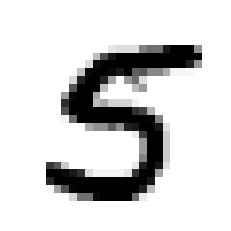

In [8]:
some_digit = X[43233]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary",)
plt.axis("off")
plt.show()

In [9]:
y[43233]    #returns a string with the label

'5'

In [10]:
y = y.astype(np.uint8) #transform y valus from str to int

In [11]:
#train/test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

## **Binary classifier**

simply classifier for 5 and not-5 classes

In [41]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [42]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

###**Performance Measures**


####**Cross-Validation**



In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

####**Confusion Matrix**

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

####**Precision/Recall**

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "g-", label="Precision")
  plt.plot(thresholds, recalls[:-1], "b--", label="Recall")

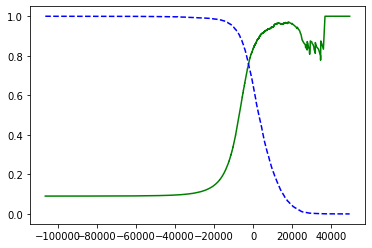

In [19]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

####**ROC Curve** 

In [20]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [21]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

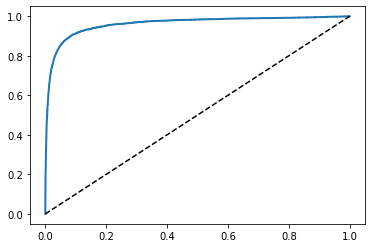

In [22]:
plot_roc_curve(fpr, tpr)
plt.show()

In [23]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=3, method="predict_proba")

In [24]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

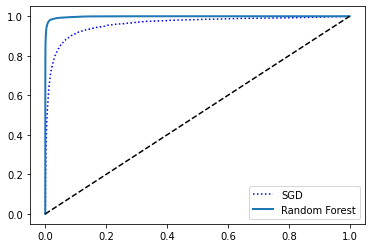

In [25]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## **Multiclass classifier**



In [43]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
sgd_clf.decision_function([some_digit])

array([[-41690.57533362, -31243.38245457, -21057.59567567,
        -11093.82542504, -21463.72272027,   4395.41315598,
        -57542.63501558, -39636.18852588,  -2698.47072815,
        -20871.09976706]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [46]:
#scale the inputs to improve the score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

###**Error Analysis**

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

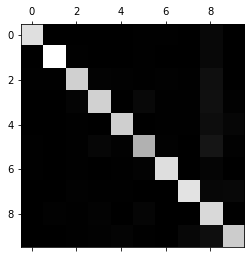

In [36]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

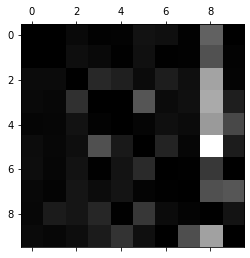

In [37]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

###**XGBoost**

In [27]:
XGB_clf = XGBClassifier()
XGB_clf.fit(X_train, y_train)
XGB_clf.predict([some_digit])

array([5], dtype=uint8)

In [28]:
cross_val_score(XGB_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9315, 0.9301, 0.9335])

###**KNeighborsClassifier**

In [32]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train, y_train)
knn_clf.predict([some_digit])

array([5], dtype=uint8)

In [33]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9621, 0.962 , 0.9645])